# Kuramoto-Sivashinsky (KS) equation: single parameter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from plots import contour_plot

Ntraj_to_simulate = 25
Ntime_for_nn = 250

## Generation of the data

Solving in $[0,L]$ with $L=2\pi$ for $u_0 = \cos(2 \pi\,x/L)\cdot (1+\sin(2 \pi\,x/L))$

In [2]:
N = 2**11
L = 2 * np.pi * 16

tmax = 100
dt = 1e-2
saved_steps = Ntime_for_nn

x = L * np.linspace(0, 1, N, endpoint=False)

For different values of viscosity $\nu$, we generate the data.

In [3]:
from ks import renshaw
from tqdm import tqdm
from numpy.random import default_rng

nu = np.linspace(1, 1.5, Ntraj_to_simulate)
omega = [1] # np.linspace(1, 4, 20)

Ns = len(nu) * len(omega)

bar = tqdm(range(Ns), 'Solving parametric KS equation')
snapshots_data = list()
params = list()

for _nu in nu:
    for ii in range(len(omega)):
        
        u0 = lambda x: np.cos(omega[ii] * 2 * np.pi * x / L) * (1 + np.sin(omega[ii] * 2 * np.pi * x / L))

        snapshots_data.append(renshaw(x, u0, tmax = tmax, N = N, h = dt, nu = _nu, saved_steps=saved_steps))
        params.append(np.array([_nu, omega[ii]]))
        
        bar.update(1)
        
params = np.asarray(params)

Solving parametric KS equation:   0%|          | 0/25 [00:00<?, ?it/s]

Solving parametric KS equation: 100%|██████████| 25/25 [00:56<00:00,  2.25s/it]

Let us check that the IC satisfy the following condition
\begin{equation*}
\int_0^L u_0(x)\,dx=0
\end{equation*}

In [4]:
from scipy.integrate import quad
quad(u0, 0, L)[0]

1.6741768790441432e-14

### Comparison plots and saving

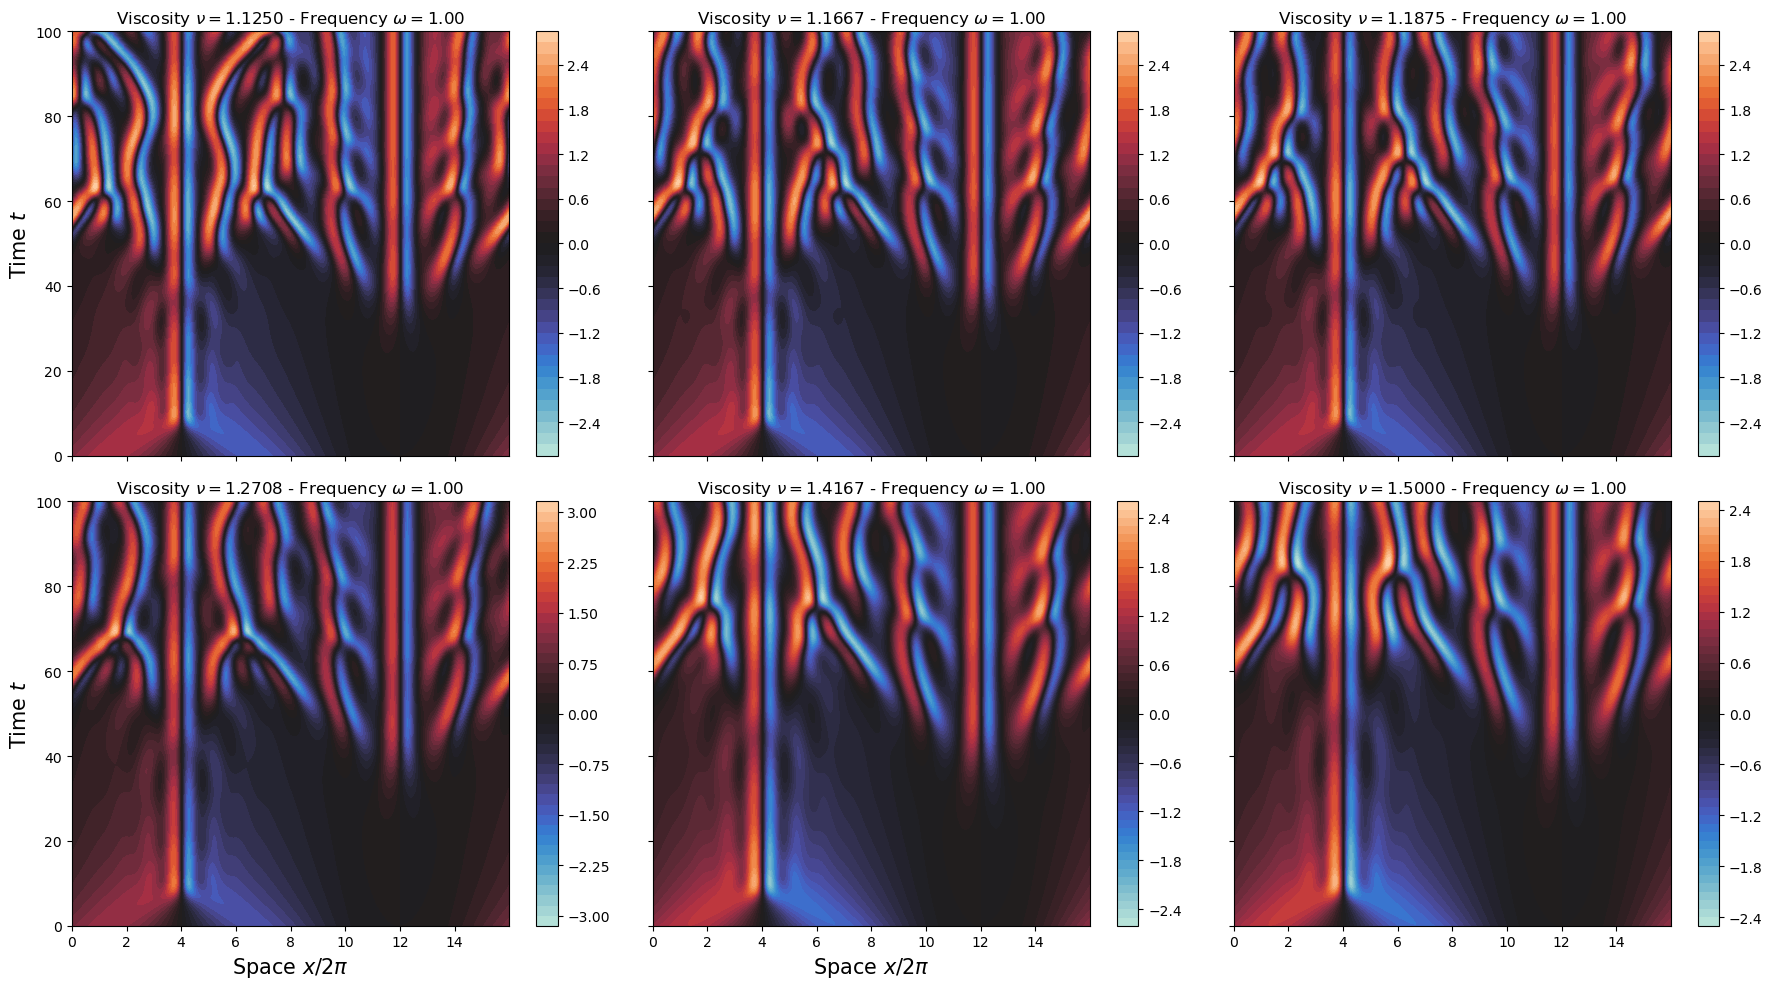

In [5]:
import seaborn as sns

nrows = 2
ncols = 3

param_to_plot = np.sort(np.random.choice(len(snapshots_data), nrows * ncols, replace=False))

fig, axs = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize=(6 * ncols, 5*nrows))

axs = axs.flatten()

levels = 50

for ii, param in enumerate(param_to_plot):
    contour_plot(axs[ii], *snapshots_data[param], 
                 title=r'Viscosity $\nu={:.4f}$'.format(params[param,0])+r' - Frequency $\omega={:.2f}$'.format(params[param,1]), 
                 levels=levels, cmap=sns.color_palette('icefire', as_cmap=True))

axs = axs.reshape(nrows, ncols)
for jj in range(nrows):
    axs[jj, 0].set_ylabel(r'Time $t$', fontsize=15)

axs[-1,0].set_xlabel(r'Space $x/2\pi$', fontsize=15)
axs[-1,1].set_xlabel(r'Space $x/2\pi$', fontsize=15)

plt.tight_layout()

Let us store the snapshots

In [6]:
import os

snaps = dict()
domain = x
snaps['t'] = snapshots_data[0][1]
snaps['params'] = params[:,0].reshape(-1,1)
snaps['snapshots'] = {'u': [snap[2].T for snap in snapshots_data]}

Split into train, test and validation for the parameter

In [7]:
np.random.seed(0)

ntrajectories = len(snaps['params'])
ntrain = int(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

dataset = dict()
dataset['u'] = {
    'train': np.asarray([snaps['snapshots']['u'][idx].T for idx in idx_train]),
    'valid': np.asarray([snaps['snapshots']['u'][idx].T for idx in idx_valid]),
    'test': np.asarray([snaps['snapshots']['u'][idx].T for idx in idx_test]),
}

mu = np.zeros((ntrajectories, Ntime_for_nn+1, 1))
for idx in range(ntrajectories):
    mu[idx] = snaps['params'][idx]

dataset['params'] = {
    'train': mu[idx_train],
    'valid': mu[idx_valid],
    'test':  mu[idx_test],
}

## Singular Value Decomposition

In [8]:
from sklearn.utils.extmath import randomized_svd
import numpy as np
from scalers import ICStdScaler, ICMinMaxScaler

rescaling_snaps = list()
var_names = ['u']
Nmodes = []

u_total = dict()
s_total = dict()

modes_number = [20]

for field_i, field in enumerate(var_names):
    u = dataset[field]['train'].reshape(-1, len(x)).T
    rescaling_snaps.append(ICStdScaler(u))
    
    X = rescaling_snaps[field_i].transform(u)
    
    _Nmodes = modes_number[field_i]
    
    Nmodes.append(_Nmodes)
    
    u_svd, s_svd, v_svd = randomized_svd(X, n_components = _Nmodes, n_iter = 'auto')

    if field_i == 0:
        v_total = v_svd
    else:
        v_total = np.vstack((v_total, v_svd))
        
    s_total[field] = s_svd.flatten()
    u_total[field] = u_svd
        
Nmodes = np.asarray(Nmodes)

Let us plot the sing vals

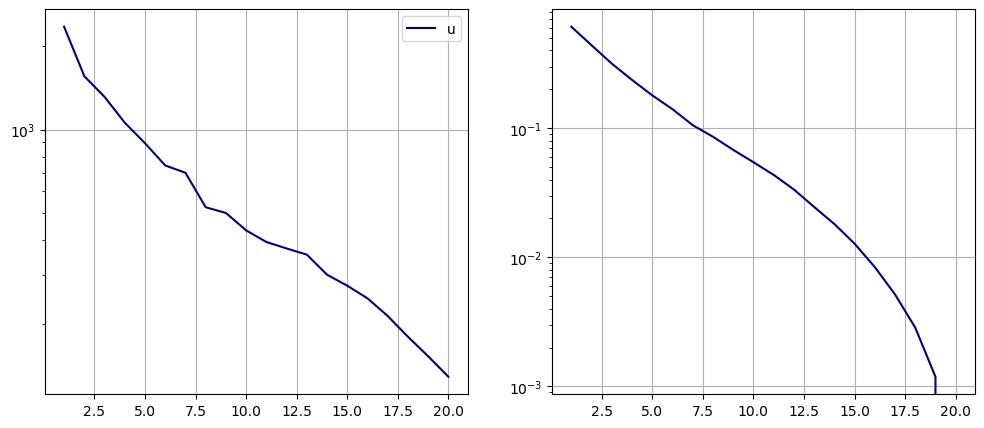

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

colors = cm.jet(np.linspace(0,1,len(var_names)))
for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, Nmodes[field_i]+1, 1)
    axs[0].semilogy(N_plot, s_total[field], color=colors[field_i], label=field)
    axs[1].semilogy(N_plot, 1-np.cumsum(s_total[field]**2) / np.sum(s_total[field]**2), color=colors[field_i], label=field)
axs[0].grid()
axs[1].grid()
axs[0].legend()

Checking the training error

In [10]:
print(v_total.shape)

# Check errors

for field_i in range(len(var_names)):
    field = var_names[field_i]

    true_field = dataset[field]['train'].reshape(-1, len(x)).T
    rec = rescaling_snaps[field_i].inverse_transform(u_total[field] @ (np.diag(s_total[field]) @ v_total[np.sum(Nmodes[:field_i]) : np.sum(Nmodes[:field_i+1])]))

    errors = np.linalg.norm(rec - true_field, axis = 0) / np.linalg.norm(true_field, axis=0)

    print(field)
    print('   max = {:.3e}'.format(np.max(errors)) +' and ave {:.3e}'.format(np.mean(errors)))

(20, 5020)
u
   max = 1.422e-01 and ave 5.127e-02


Let us store the POD coefficients

In [11]:
_v_POD = {
    'train': np.linalg.multi_dot([np.linalg.inv(np.diag(s_total['u'])),  u_total['u'].T, rescaling_snaps[0].transform(dataset['u']['train'].reshape(-1, len(x)).T)]),
    'valid': np.linalg.multi_dot([np.linalg.inv(np.diag(s_total['u'])),  u_total['u'].T, rescaling_snaps[0].transform(dataset['u']['valid'].reshape(-1, len(x)).T)]),
    'test':  np.linalg.multi_dot([np.linalg.inv(np.diag(s_total['u'])),  u_total['u'].T, rescaling_snaps[0].transform(dataset['u']['test'].reshape(-1, len(x)).T)]),
}

Let us reshape the coefficients

In [12]:
v_POD = {
    'train': _v_POD['train'].T.reshape(ntrain, Ntime_for_nn+1, Nmodes[0]),
    'valid': _v_POD['valid'].T.reshape(nvalid, Ntime_for_nn+1, Nmodes[0]),
    'test':  _v_POD['test'].T.reshape(  ntest, Ntime_for_nn+1, Nmodes[0])
}

Let us make a contour plot on the test set

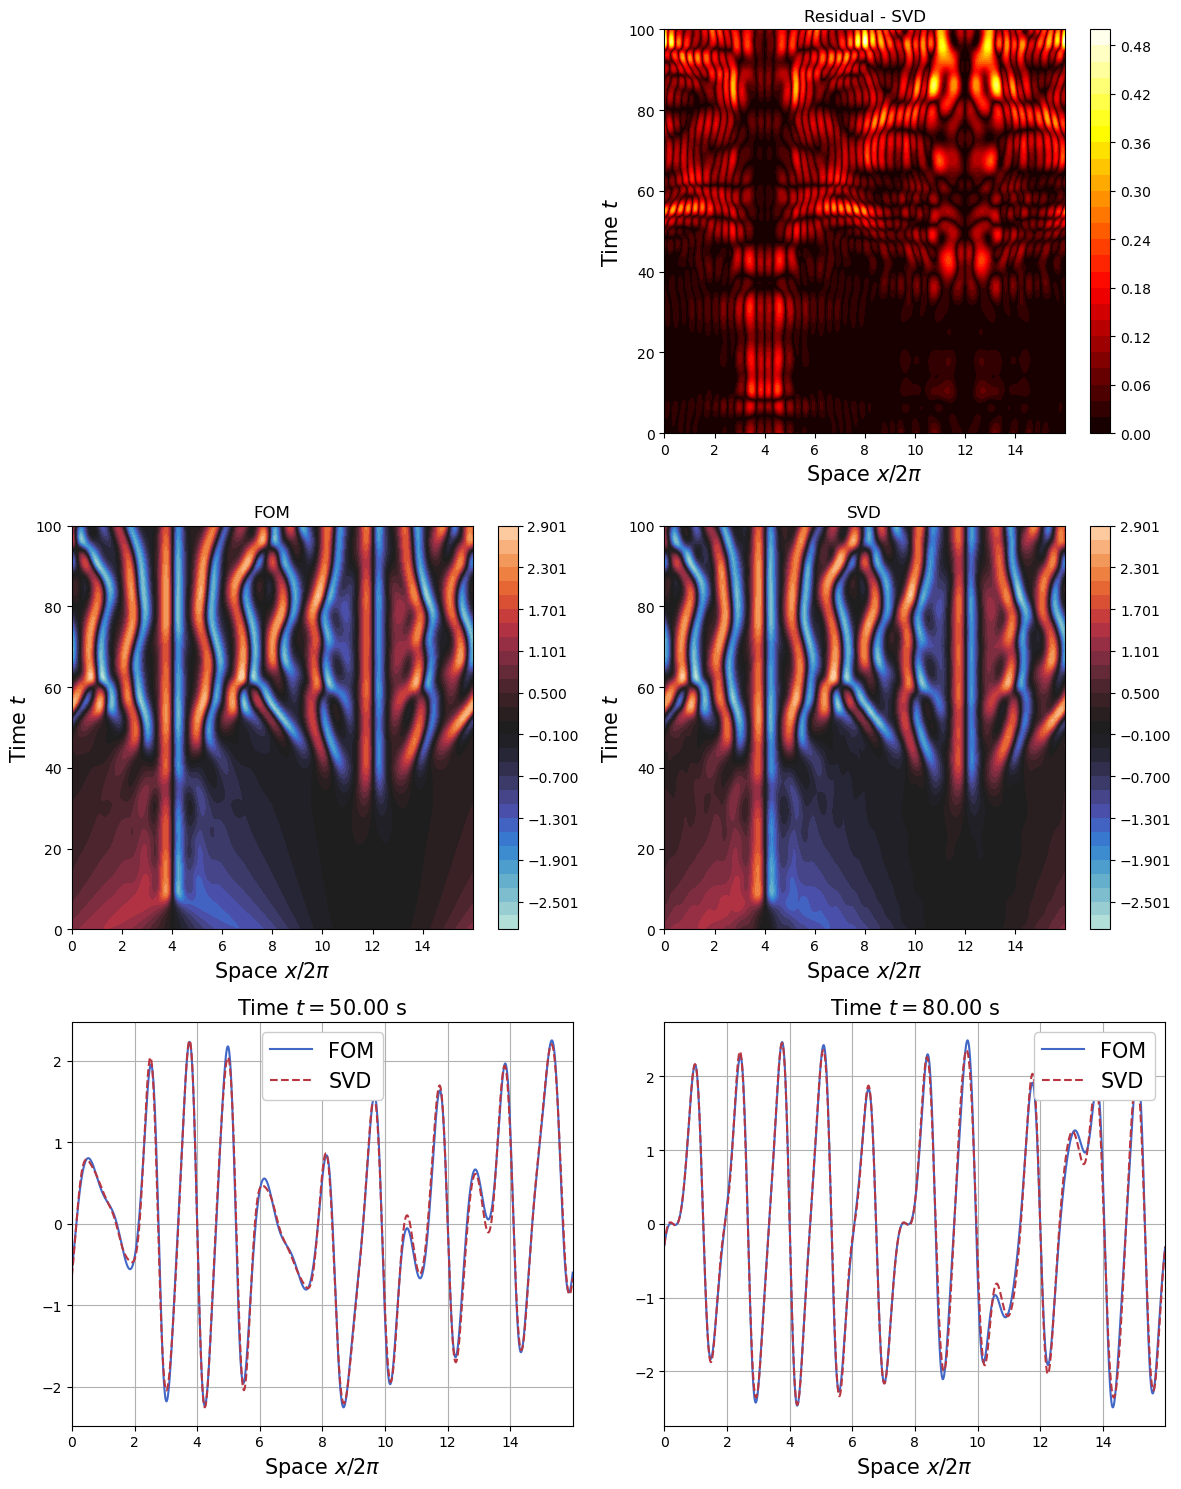

In [13]:
from plots import plot_FOM_vs_Recon

recons = {'SVD': rescaling_snaps[field_i].inverse_transform(np.linalg.multi_dot([u_total[field], 
                                                            np.diag(s_total[field]), 
                                                            v_POD['test'][0, :].T]))}
plot_FOM_vs_Recon(domain, snaps['t'], dataset[field]['test'][0].T, recons, time_idx = [0.5, 0.8])

## Compute Measures

In [14]:
measured_field = 0

from tqdm import tqdm
num_sensors = 3
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

n_configurations = 5
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)
sensors = list()

snap_measurements = list()

np.random.seed(109) # set seed for reproducibility
for kk in tqdm(range(n_configurations), 'Creating sensors'):

    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(domain, size=num_sensors, replace=False), dtype=int)

    snap_measurements.append({
        key: dataset[var_names[measured_field]][key][:, :, idx_sensor_locations[:,0]]
        for key in list(dataset[var_names[measured_field]].keys())
    })

Creating sensors: 100%|██████████| 5/5 [00:00<00:00, 1504.41it/s]


Let us add uncorrelated Gaussian noise to the measures

In [ ]:
noise_value = 2.5/100
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append({
        key: snap_measurements[kk][key] + np.random.normal(scale=noise_value, size=snap_measurements[kk][key].shape)
        for key in list(snap_measurements[kk].keys())
    })

## Padding

In [16]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

import sys

sys.path.append('../')

from utils.processdata import Padding, TimeSeriesDataset
import torch

lags = 30

train_data_in = [Padding(torch.from_numpy(Xsensor[kk]['train']), lags) for kk in range(n_configurations)]
valid_data_in = [Padding(torch.from_numpy(Xsensor[kk]['valid']), lags) for kk in range(n_configurations)]
test_data_in  = [Padding(torch.from_numpy(Xsensor[kk]['test']), lags) for kk in range(n_configurations)]

train_data_out = [Padding(torch.cat((torch.from_numpy(v_POD['train']), 
                                     torch.from_numpy(dataset['params']['train'])), 
                                     axis=2), 1).squeeze(1) 
                                     for kk in range(n_configurations)]
valid_data_out = [Padding(torch.cat((torch.from_numpy(v_POD['valid']), 
                                     torch.from_numpy(dataset['params']['valid'])), 
                                     axis=2), 1).squeeze(1) 
                                     for kk in range(n_configurations)]
test_data_out = [Padding(torch.cat((torch.from_numpy(v_POD['test']), 
                                     torch.from_numpy(dataset['params']['test'])), 
                                     axis=2), 1).squeeze(1) 
                                     for kk in range(n_configurations)]

train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out[kk]) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out[kk]) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk], test_data_out[kk]) for kk in range(n_configurations)]

## SHRED

Let us train the SHRED models for each configuration

In [17]:
# SHRED training

from utils.models import SHRED, fit

shred = list()

for kk in range(n_configurations):

    print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

    shred.append(SHRED( num_sensors, sum(Nmodes) + 1, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1))
    fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                            batch_size = 64, epochs = 3000, lr = 1e-4, verbose = True, patience = 50)

    print(' ')

Training SHRED - configuration 1/5
Training done: Training loss = 4.25% 	 Validation loss = 7.45%       
 
Training SHRED - configuration 2/5
Training done: Training loss = 3.80% 	 Validation loss = 8.21%       
 
Training SHRED - configuration 3/5
Training done: Training loss = 3.94% 	 Validation loss = 6.58%       
 
Training SHRED - configuration 4/5
Training done: Training loss = 4.08% 	 Validation loss = 8.23%       
 
Training SHRED - configuration 5/5
Training done: Training loss = 4.08% 	 Validation loss = 7.06%       
 


Let us check the test errors of the POD coefficients

In [18]:
# SHRED ERRORS ON TEST DATA
from utils.processdata import num2p, mre

[_shred.freeze() for _shred in shred]

Ytest_POD_hat = np.asarray([shred[kk](test_data_in[kk]).numpy() for kk in range(n_configurations)])

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0),
    'std':  Ytest_POD_hat.std(axis=0)
}

# The test data are independent on the configurations of the sensors
print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_data_out[0],
                                                                            Ytest_POD_pred['mean'])))

Mean relative SHRED prediction error on POD coeffs: 4.04%.


Let us decode the full state space

In [19]:
Ytest_hat = {
    'mean': rescaling_snaps[0].inverse_transform(   np.linalg.multi_dot([
                                                    u_total['u'], np.diag(s_total['u']), 
                                                    Ytest_POD_pred['mean'].T[:sum(Nmodes)]
                                                ])).T.reshape(ntest, Ntime_for_nn+1, len(x)),
    'std': rescaling_snaps[0].inverse_std_transform(    np.linalg.multi_dot([
                                                        u_total['u'], np.diag(s_total['u']), 
                                                        Ytest_POD_pred['std'].T[:sum(Nmodes)]
                                                    ])).T.reshape(ntest, Ntime_for_nn+1, len(x)),
            }
Ytest = rescaling_snaps[0].inverse_transform(np.linalg.multi_dot([
                                    u_total['u'], np.diag(s_total['u']), 
                                    test_data_out[kk].reshape(Ytest_POD_pred['mean'].shape).numpy().T[:sum(Nmodes)]
                                ])).T.reshape(ntest, Ntime_for_nn+1, len(x))

print("Mean relative SHRED prediction error on full space: %s." % num2p(mre(torch.from_numpy(Ytest_hat['mean']),
                                                                            torch.from_numpy(Ytest))))

Mean relative SHRED prediction error on full space: 11.87%.


Let us make a contour plot

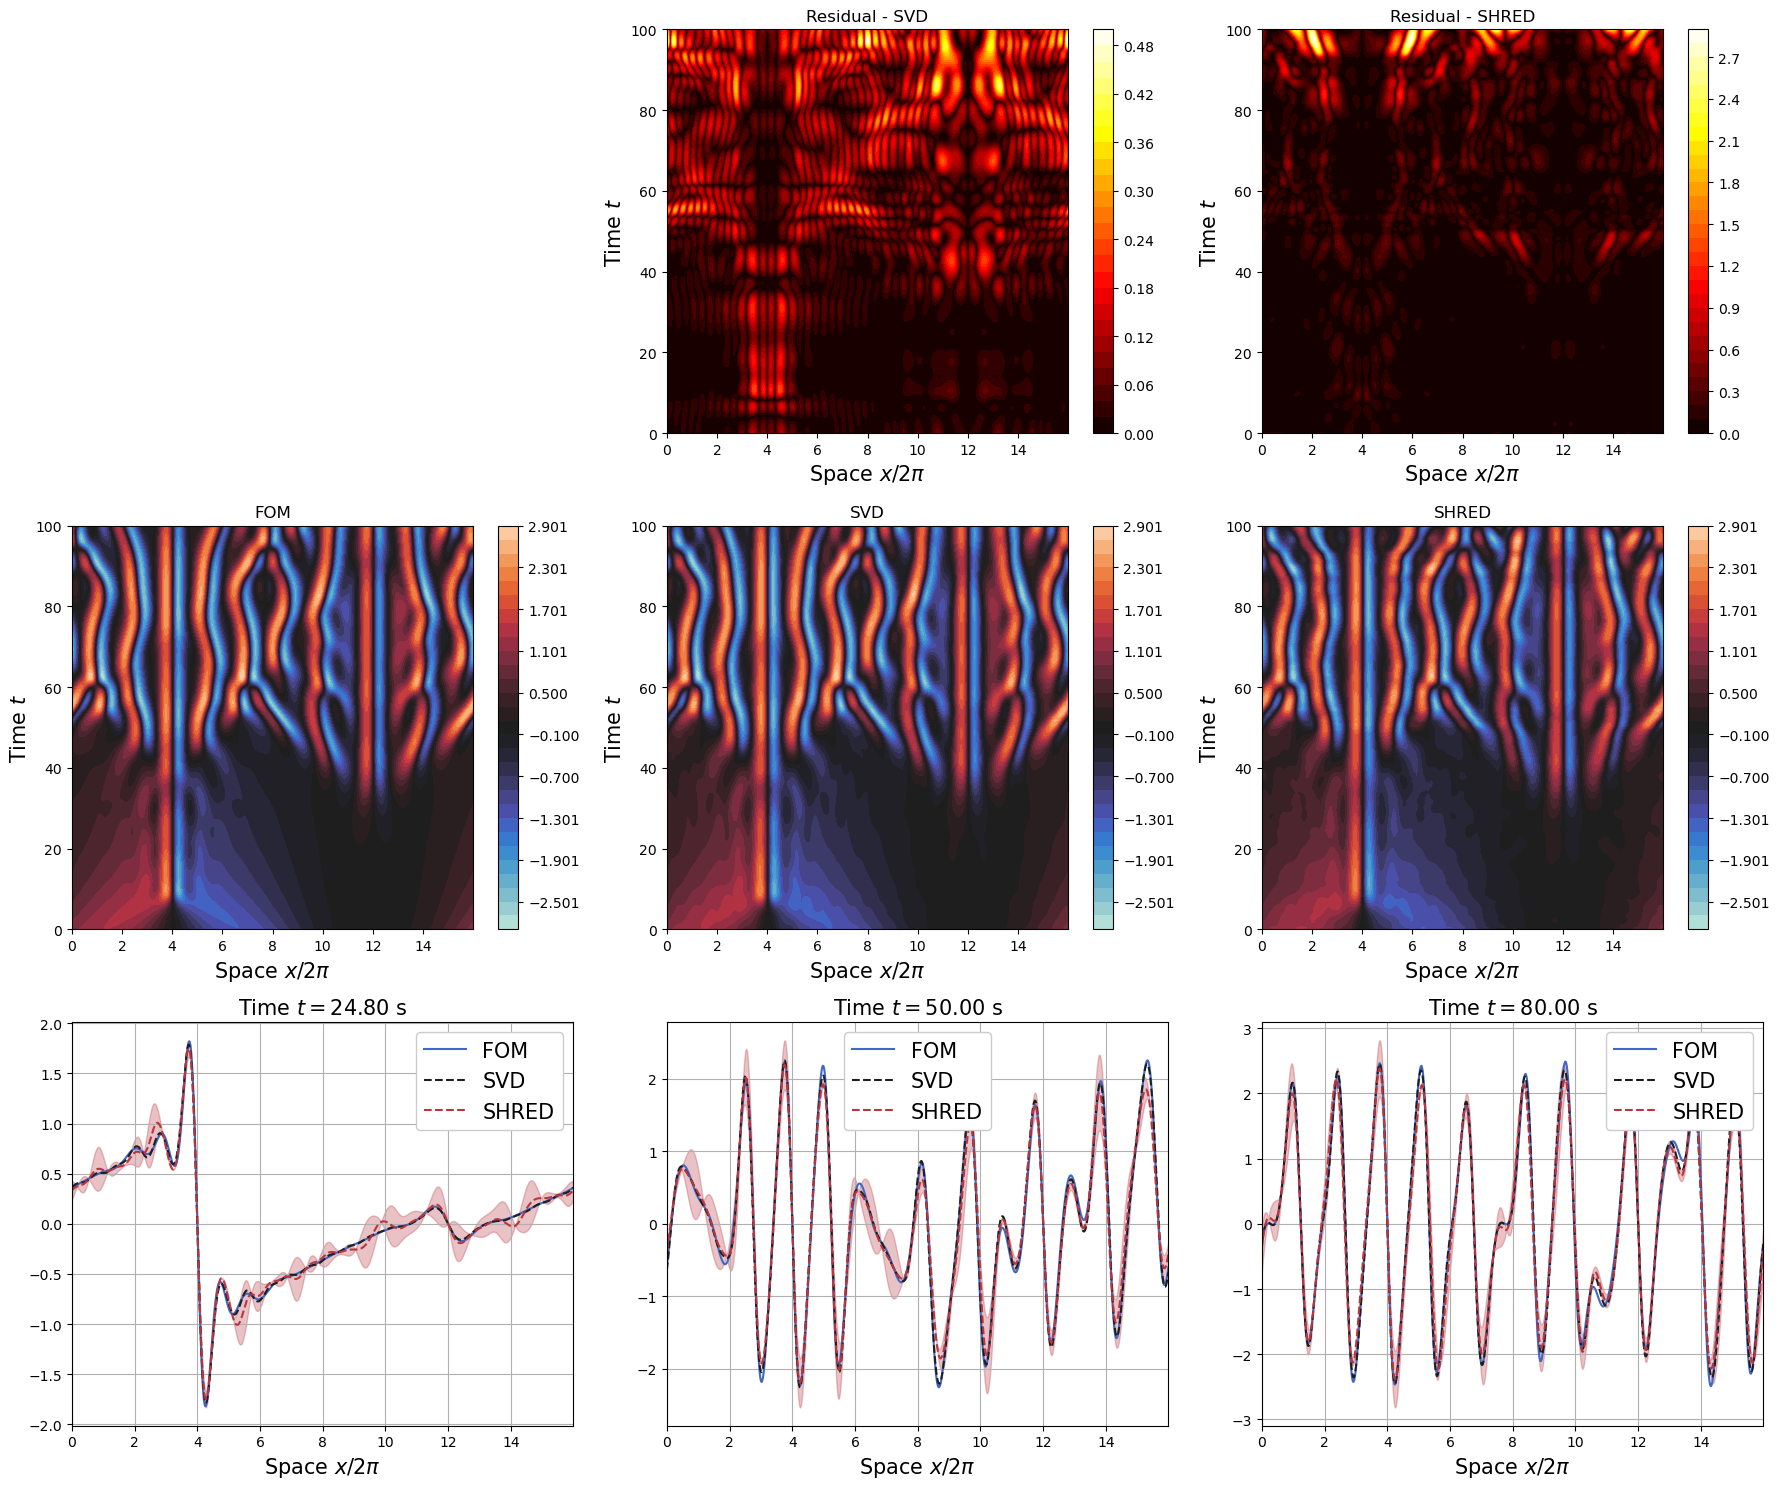

In [ ]:
mu_to_plot = 0

recons = {'SVD': Ytest[mu_to_plot].T,
          'SHRED': Ytest_hat['mean'][mu_to_plot].T}

std_recons = {'SVD': None,
            'SHRED': Ytest_hat['std'][mu_to_plot].T}

plot_FOM_vs_Recon(domain, snaps['t'], dataset[field]['test'][mu_to_plot].T, recons,
                    std_recons = std_recons,
                    time_idx = [0.25, 0.5, 0.8],
                    filename = 'KS', format='png')